<a href="https://colab.research.google.com/github/gffranca/DataAnalytics/blob/main/MVP2/MVP_Car_Brands.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classificador de imagens multiclasse - Fabricantes de carro**
### MVP de Machine Learning & Computer Vision
#### Aluno: Guilherme Freitas França
#### Instituição: PUC-Rio

## **1. Introdução e Definição do Problema**

### **1.1 Introdução**

**Contexto:** Para este trabalho, foi escolhido um Dataset de logotipos de oito marcas de carros distintas. As marcas incluídas neste conjunto de imagens são Mercedes-Benz, BMW, Audi, Toyota, Honda, Ford, Chevrolet e Volkswagen. O desafio é desenvolver um modelo de visão computacional, utilizando deep learning, capaz de classificar corretamente uma imagem em uma das oito categorias representadas pelos logotipos das marcas automotivas mencionadas.

Este tipo de problema é chamado de Problema Multiclasse de Classificação, no qual o objetivo é atribuir uma única classe a cada instância de dados entre múltiplas classes possíveis.



**Estrutura:** O notebook está dividido assim:

1. Introdução e Definição do Problema
2. Sobre o notebook
3. Carga e Análise do Dataset
4. Preparação do Dataset
5. Modelos de Deep Learning
6. Treinamento do Modelo
7. Teste/Execução do Modelo
8. Conclusões

### **1.2 Sobre o Dataset**

O conjunto de imagens utilizados neste trabalho está disponível no <a href="https://www.kaggle.com/datasets/volkandl/car-brand-logos">Kaggle</a>, e é composto por imagens de logotipos de oito marcas de carros e objetos que contêm esses logotipos.

O dataset é dividido em conjuntos de treinamento e teste, com mais de 300 imagens por logotipo no conjunto de treinamento e 63 imagens por logotipo no conjunto de teste. A organização dos dados em subpastas facilita o acesso e a manipulação durante o treinamento e teste dos modelos de deep learning.

## **2. Sobre o notebook**

### **2.1 Importando as bibliotecas necessárias**

Inicia-se o código importando as bibliotecas que serão utilizadas, assim como reaizando o filtro de warnings, para limpar possível poluição e avisos desnecessários das libs.

In [1]:
import os
import random
from datetime import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import sklearn.metrics as skm
from sklearn.metrics import confusion_matrix, classification_report

from PIL import Image
import IPython.display

# Configurando filtro de Warnings
import warnings
warnings.filterwarnings('ignore')

### **2.2 Utilidades**

A função **`set_seed`** é utilizada para manter a reprodutibilidade do código por conta das funções pseudo--aleatórias.

In [2]:
SEED = 42
def set_seed(seed=0):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

set_seed(SEED)

A função **`get_images_from_dir`** recebe um caminho de diretório e retorna uma 3-upla com o path da imagem, a classe que ela pertence, e o diretório que ela pertencia (Treino ou Teste).

In [3]:
def get_images_from_dir(dir: str) -> list[tuple[str, str, str]]:
    images_with_class = []
    for root, folders, files in os.walk(dir):
        for file in files:
            if file.lower().endswith((".png", ".jpg", ".jpeg", ".bmp")):
                images_with_class.append((os.path.join(root, file), root.split('/')[-1], root.split('/')[-2]))
    return images_with_class

A função **`_obter_tamanho_imagem`** recebe uma string path para uma imagem e retorna uma tupla com sua largura e altura.

In [4]:
def _obter_tamanho_imagem(imagem: str) -> tuple[int, int]:
    with Image.open(imagem) as img:
        return img.width, img.height

A função **`save_model`** recebe um modelo, suas métricas e o tipo do treinamento, e salva este modelo para o seu uso posterior.

In [5]:
def save_model(model, model_metrics, training):
    now = datetime.now()
    formatted_datetime = now.strftime('%Y-%m-%dT%H%M')

    model_dir = 'trained_model_' + formatted_datetime
    model_name = model_dir + '.h5'
    metrics_name = training + '_metrics.png'

    model_path = os.path.join(model_dir, model_name)
    metrics_path = os.path.join(model_dir, metrics_name)

    model.save(model_path)
    model_metrics.savefig(metrics_path)
    print("Modelo salvo: ", model_name)

A função **`plot_model_metrics_from_training`** recebe um historico do treinamento de um modelo (através do método `model.fit()`) e exibe a evolução do modelo durante o treinamento; Tanto nos dados de treinamento quanto nos dados de validação.

In [6]:
def plot_model_metrics_from_training(history):
    n_subplots = 2
    if 'lr' in history.history.keys():
        n_subplots = 3

    fig, ax = plt.subplots(nrows=n_subplots, ncols=1, figsize=(12, 10))

    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    ax[0].set_title('Training Accuracy vs. Epochs')
    ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
    ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend(loc='best')

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    ax[1].set_title('Training/Validation Loss vs. Epochs')
    ax[1].plot(train_loss, 'o-', label='Train Loss')
    ax[1].plot(val_loss, 'o-', label='Validation Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend(loc='best')

    if 'lr' in history.history.keys():
        learning_rate = history.history['lr']
        ax[2].set_title('Learning Rate vs. Epochs')
        ax[2].plot(learning_rate, 'o-', label='Learning Rate')
        ax[2].set_xlabel('Epochs')
        ax[2].set_ylabel('Loss')
        ax[2].legend(loc='best')

    plt.tight_layout()
    plt.show()
    return fig

A função **`plot_confusion_matrix`** recebe os valores verdadeiros, os preditos pelo modelo e as classes, e exibe a matriz de confusão.

In [7]:
def plot_confusion_matrix(y_true, y_pred, labels, title='Confusion Matrix', cmap='YlGnBu'):
    cf_mtx = confusion_matrix(y_true, y_pred)

    group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
    box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
    box_labels = np.asarray(box_labels).reshape(8, 8)

    plt.figure(figsize = (12, 10))
    sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
            cmap=cmap, fmt="", annot=box_labels)
    plt.title(title)
    plt.xlabel('Predicted Classes')
    plt.ylabel('True Classes')
    plt.show()

A função **`show_predictions_examples`** recebe um ImageDataGenerator, os valores verdadeiros e os preditos pelo modelo, as classes, um filtro, o tamanho das imagens que serão exibidas, e o título desta exibição; E então, seleciona 10 avaliações aleatórias feitas pelo modelo e as exibe.

In [8]:
def show_predictions_examples(test_generator, y_true, y_pred, labels, filter, height, width, title):
    y_true_filtered = y_true[filter]
    y_pred_filtered = y_pred[filter]

    test_images = test_generator.filenames
    test_img = np.asarray(test_images)[filter]
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))

    for i in range(2):
        for j in range(5):
            idx = np.random.randint(0, len(test_img))
            true_index = y_true_filtered[idx]
            true_label = labels[true_index]
            predicted_index = y_pred_filtered[idx]
            predicted_label = labels[predicted_index]
            ax[i, j].set_title(f"Predicted Label: {predicted_label}\nTrue Label: {true_label}")
            img = keras.preprocessing.image.load_img(test_img[idx], target_size=(height, width))
            ax[i, j].imshow(img)
            ax[i, j].axis("off")

    plt.tight_layout()
    plt.suptitle(title, fontsize=20)
    plt.show()

## **3. Carga e Análise do Dataset**

### **3.1 Importação do Kaggle**

Este trecho de código utiliza a API do Kaggle para baixar o conjunto de dados "car-brand-logos" disponível no repositório "volkandl/car-brand-logos".

O script faz o download do conjunto de dados especificado usando o comando "kaggle datasets download", armazenando-o como um arquivo zip localmente. A seguir, o arquivo zip é descompactado no diretório de destino especificado.

Esse processo automatizado simplifica a obtenção e preparação do dataset para uso posterior e para o compartilhamento do notebook.

Para tal, basta configurar <a href="https://www.kaggle.com/discussions/general/74235">assim</a> o arquivo **kaggle.json** para utilização da API do Kaggle.

In [9]:
DATASET_KAGGLE_NAME = 'volkandl/car-brand-logos'
DATASET = 'car-brand-logos'

with open('kaggle.json', 'w') as f:
    f.write('{"username":"mrfrench","key":"5ec582fe257863f4ecdf70540b680b16"}')

!rm -r $DATASET

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d $DATASET_KAGGLE_NAME

zip_file = f"{DATASET}.zip"
destination_dir = f"/content/"

if not os.path.exists(zip_file):
    print(f"Error: {zip_file} not found.")
else:
    !unzip -q $zip_file -d $destination_dir
    !rm $zip_file

 99% 215M/217M [00:07<00:00, 33.5MB/s]
100% 217M/217M [00:07<00:00, 29.6MB/s]
replace /content/Car_Brand_Logos/README.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


### **3.2 Criação de colunas auxiliares**

A partir do diretório que se encontra o dataset, cria um dataframe pandas para facilitar o controle e visualização das instâncias do conjunto de imagens.

<h3>Informações sobre os atributos do dataset completo:</h3>

+ ***path*** - Caminho da instância do dataset
+ ***width*** - Largura da imagem em pixels
+ ***height*** - Altura da imagem em pixels
+ ***brand*** - Marca de carro correspondente (Classe rotulada)
+ ***group*** - Separação a que a imagem pertence

In [10]:
DATASET_DIR = "Car_Brand_Logos"

dataset_images = get_images_from_dir(DATASET_DIR)
dataset_sizes = [_obter_tamanho_imagem(data[0]) for data in dataset_images]

df = pd.DataFrame({
    "path": [data[0] for data in dataset_images],
    "width": [size[0] for size in dataset_sizes],
    "height": [size[1] for size in dataset_sizes],
    "brand": [data[1] for data in dataset_images],
    "group": [data[2] for data in dataset_images]
})

O dataset original já estava dividido entre conjuntos de treinamento e teste, porém não havia uma separação específica para validação. Para remediar essa lacuna, decidiu-se dividir o conjunto de teste ao meio, reservando metade dos dados para fins de validação do modelo.

Além disso, realizamos a conversão da coluna de classe para o formato de codificação one hot encoding, garantindo que as classes fossem representadas de maneira binária.

In [11]:
# Separa 50/50 o dataset de Teste para Validação, mantendo o balancemento entre as classes
grouped_indices = df[df['group'] == "Test"].groupby('brand').apply(lambda x: x.index.tolist())

for group_indices in grouped_indices.values:
    half = len(group_indices)//2
    np.random.shuffle(group_indices)
    validation_indices = group_indices[:half]
    df.loc[validation_indices, 'group'] = "Validation"

one_hot_encoded = pd.get_dummies(df['group'])
one_hot_encoded = one_hot_encoded.astype(int)
df = pd.concat([df, one_hot_encoded], axis=1)
df.drop('group', axis=1, inplace=True)
df.head()

path  width  height     brand  Test  \
0  Car_Brand_Logos/Test/mercedes/mrc83.jpg   1500    1500  mercedes     1   
1  Car_Brand_Logos/Test/mercedes/mrc67.jpg   1920    1080  mercedes     1   
2  Car_Brand_Logos/Test/mercedes/mrc47.jpg   1371    1028  mercedes     0   
3  Car_Brand_Logos/Test/mercedes/mrc41.jpg    684     768  mercedes     0   
4  Car_Brand_Logos/Test/mercedes/mrc75.jpg    800     600  mercedes     0   

   Train  Validation  
0      0           0  
1      0           0  
2      0           1  
3      0           1  
4      0           1

### **3.3 Análise Exploratória**

A avaliação da distribuição final do dataset entre os conjuntos de treino, teste e validação é crucial para garantir uma representação adequada dos dados em cada fase do processo de modelagem. Uma das divisões comumente recomendadas é a divisão 70%, 15%, 15%, onde 70% dos dados são destinados ao treinamento do modelo, enquanto 15% são reservados para testes e os outros 15% são utilizados para validação.

No gráfico abaixo, será possível verificar o split do dataset utilizado neste trabalho.

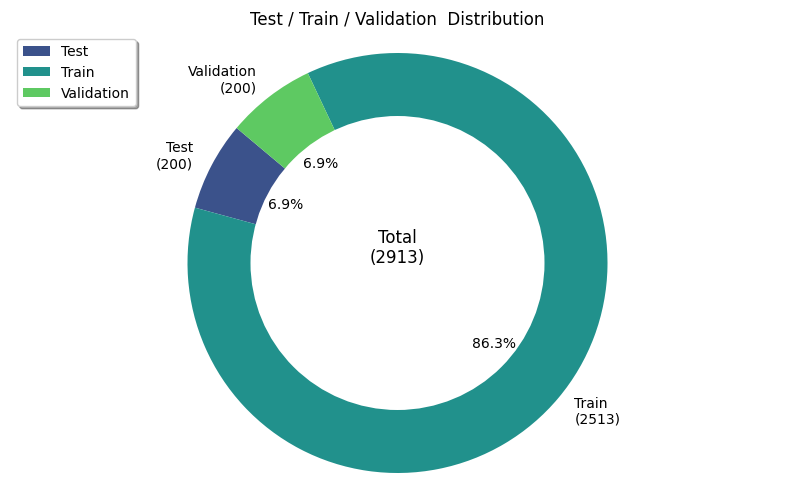

In [12]:
relevant_columns = ['Test','Train', 'Validation']
df_relevant = df[relevant_columns]
counts = df_relevant[df_relevant == 1].sum().astype(int)
total_count = counts.sum()

plt.figure(figsize=(10, 6))
patches, texts, autotexts = plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', n_colors=len(counts)))

char_labels = [f'{label}\n({count})' for label, count in zip(counts.index, counts)]
texts = plt.gca().texts[::2]
for i, (label, text) in enumerate(zip(char_labels, texts)):
    text.set_text(label)
plt.text(0, 0, f'Total\n({total_count})', fontsize=12, color='black', ha='center')
plt.title(' / '.join(relevant_columns) + '  Distribution')
plt.axis('equal')
plt.legend(counts.index, loc="upper left", shadow=True)
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.show()

Apesar desta distribuição não ser a mais recomendada, caso seja detectado overfitting, baixa generalização ou variações nos resultados, é possível alterar esta distribuição facilmente para retreinar os modelos. Além disso, podem ser utilizadas técnicas de *Data Augmentation* para melhorar esta distribuição.

De qualquer forma, é importante verificar se as classes estão balanceadas em cada conjunto do dataset.

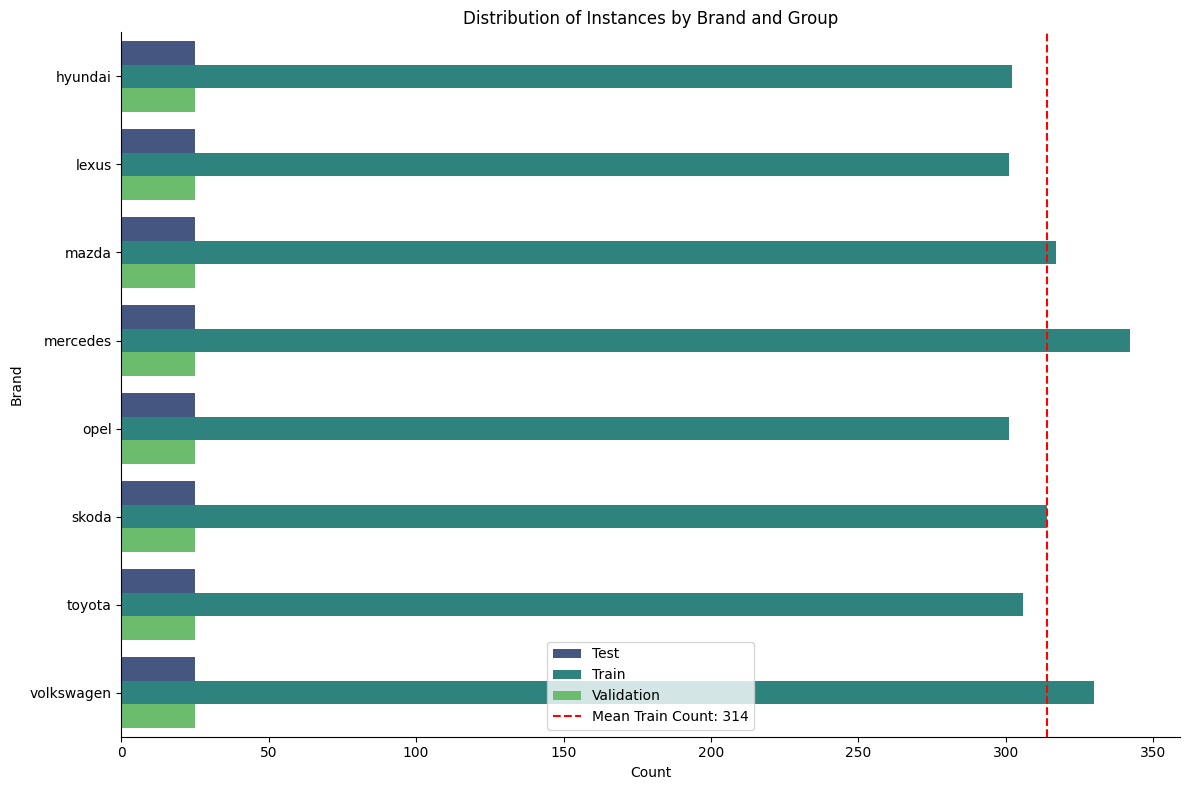

In [13]:
relevant_columns = ['brand', 'Test', 'Train', 'Validation']
df_relevant = df[relevant_columns]
counts = df_relevant.groupby('brand').sum().reset_index()
counts_melted = counts.melt(id_vars='brand', var_name='Group', value_name='Count')
mean_train_count = round(counts['Train'].mean())

plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='brand', hue='Group', data=counts_melted, palette='viridis')
plt.axvline(x=mean_train_count, color='r', linestyle='--', label=f'Mean Train Count: {mean_train_count}')
plt.xlabel('Count')
plt.ylabel('Brand')
plt.title('Distribution of Instances by Brand and Group')
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()

A fim de descobrir a dimensão ideal das imagens para a construção de modelos de Deep Learning, foram plotados dois gráficos, um scatter plot e um gráfico de densidade kernel. Esses gráficos mostram a relação entre as alturas e larguras das instâncias do dataset.

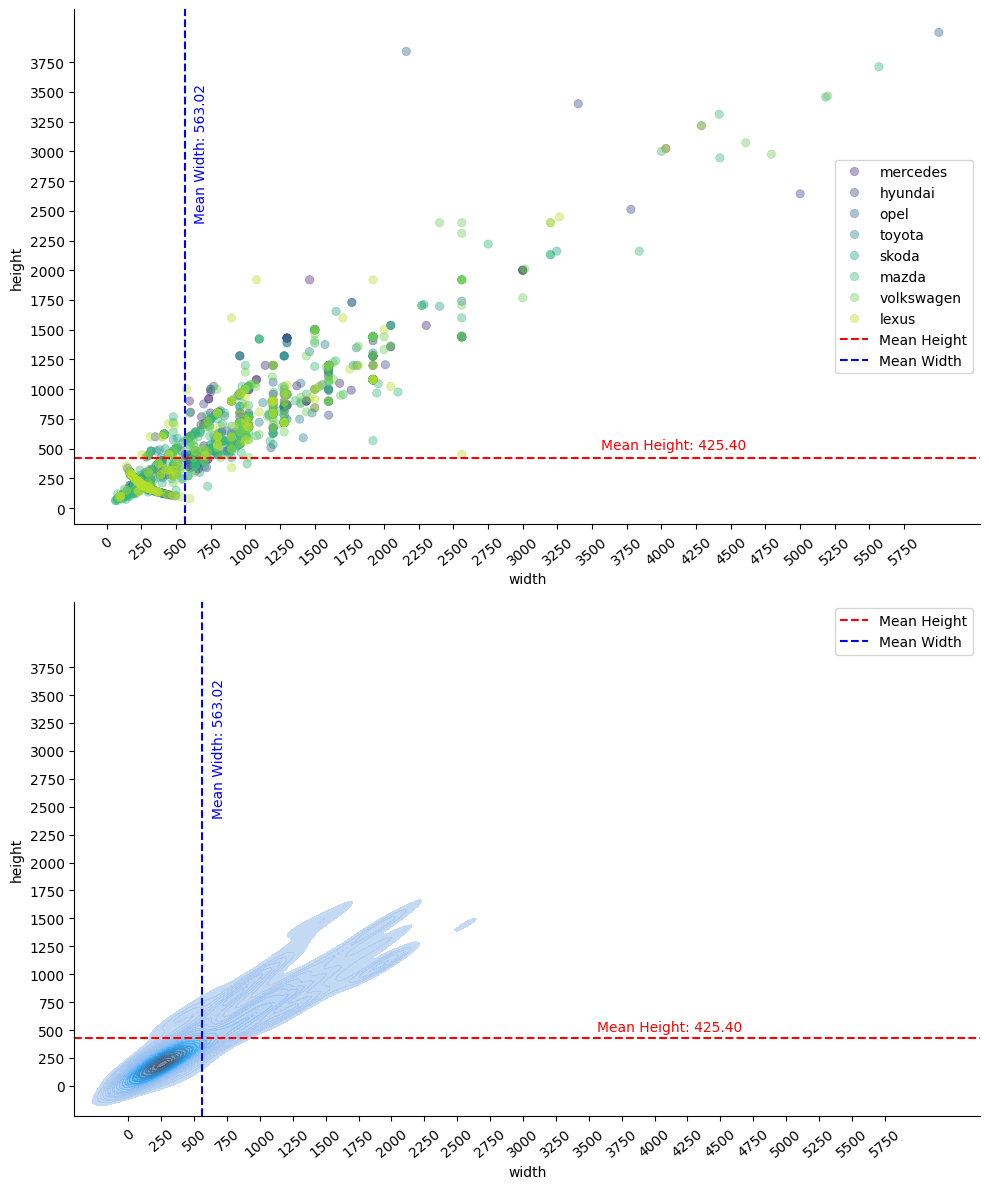

In [14]:
plt.figure(figsize=(10, 12))
mean_width = df['width'].mean()
mean_height = df['height'].mean()

plt.subplot(2, 1, 1)
sns.scatterplot(data=df, x='width', y='height', alpha=0.4, edgecolor=None, hue='brand', palette='viridis')

plt.xticks(rotation=40)
plt.xticks(range(0, df['width'].max(), 250))
plt.yticks(range(0, df['height'].max(), 250))
sns.despine(right=True, top=True)
plt.axhline(y=mean_height, color='red', linestyle='dashed', label='Mean Height')
plt.axvline(x=mean_width, color='blue', linestyle='dashed', label='Mean Width')
plt.text(mean_width + 3000, mean_height + 70, f"Mean Height: {mean_height:.2f}", color='red', fontsize=10)
plt.text(mean_width + 70, mean_height + 2000, f"Mean Width: {mean_width:.2f}", color='blue', fontsize=10, rotation=90)
plt.legend()


plt.subplot(2, 1, 2)
sns.kdeplot(data=df, x='width', y='height', fill=True, levels=30, alpha=0.7)

plt.xticks(rotation=40)
plt.xticks(range(0, df['width'].max(), 250))
plt.yticks(range(0, df['height'].max(), 250))
sns.despine(right=True, top=True)
plt.axhline(y=mean_height, color='red', linestyle='dashed', label='Mean Height')
plt.axvline(x=mean_width, color='blue', linestyle='dashed', label='Mean Width')
plt.text(mean_width + 3000, mean_height + 70, f"Mean Height: {mean_height:.2f}", color='red', fontsize=10)
plt.text(mean_width + 70, mean_height + 2000, f"Mean Width: {mean_width:.2f}", color='blue', fontsize=10, rotation=90)
plt.legend()

plt.tight_layout()
plt.show()

Observando os gráficos acima, é possível perceber como a média é sensível a casos extremos (outliers). Além disso, entende-se que a dimensão ideal para as imagens seja por volta dos 250x250 pixels.

Por fim, essas são algumas das instâncias do dataset:


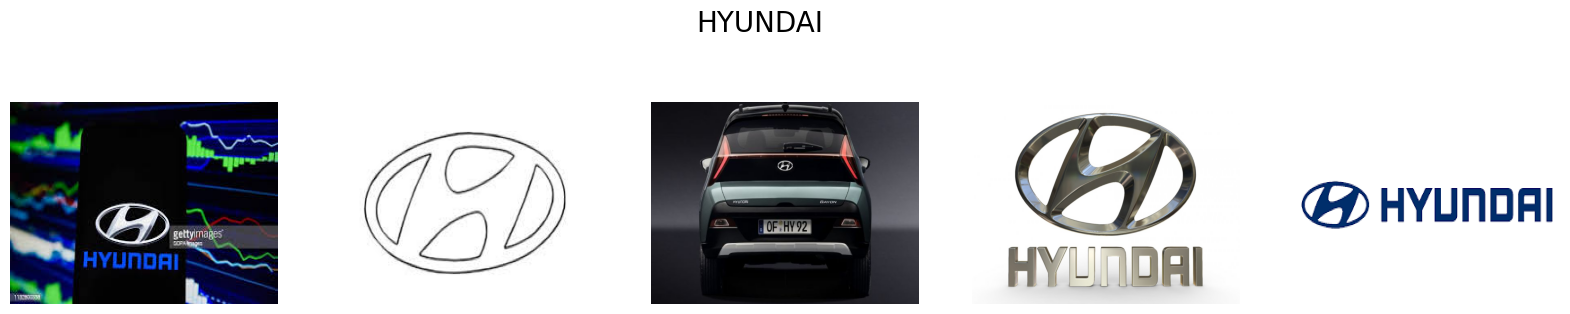

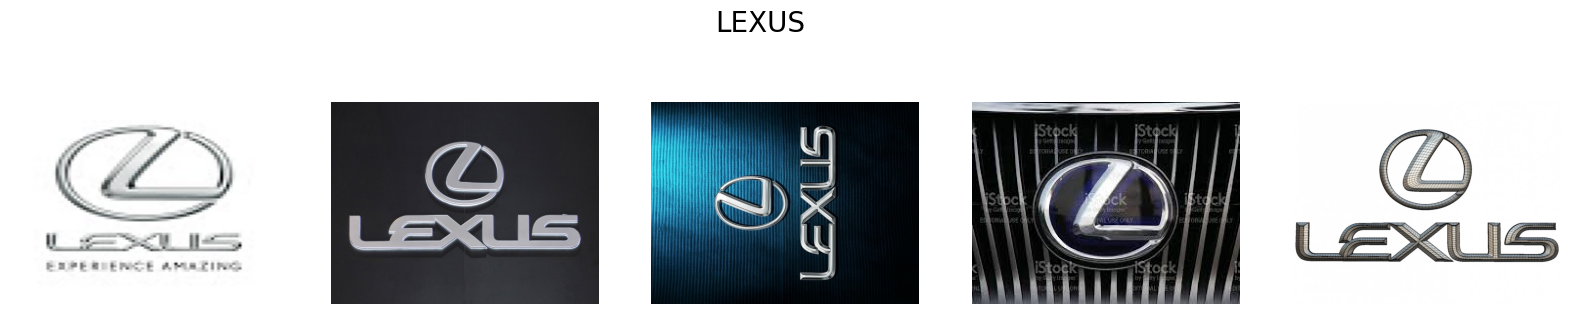

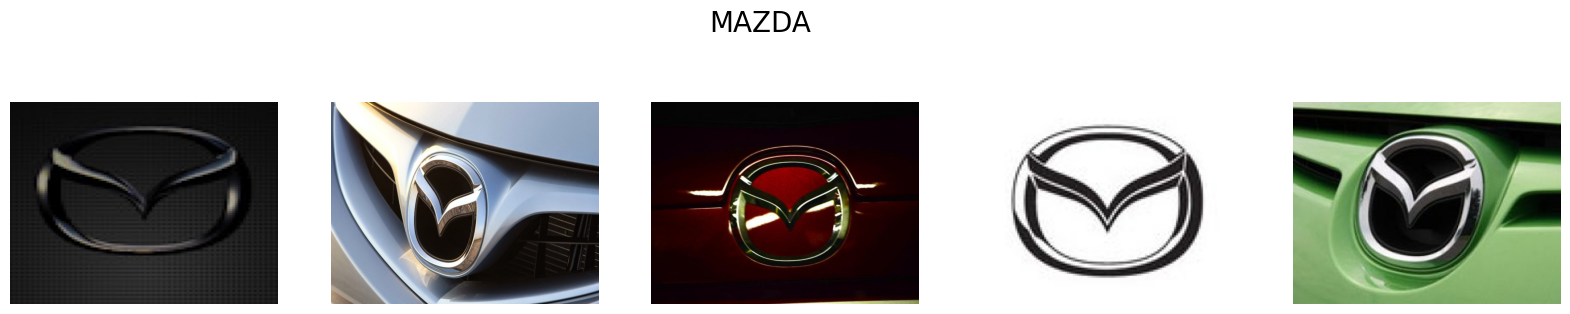

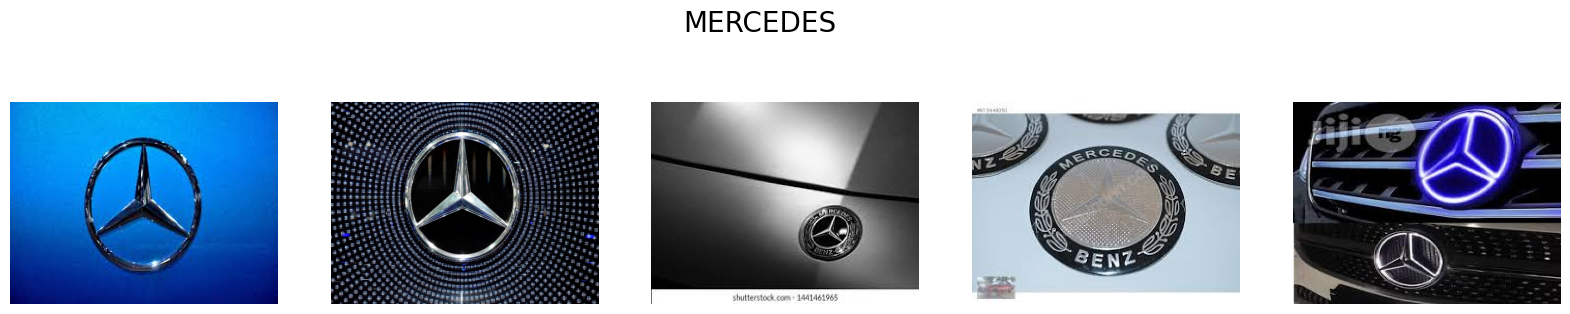

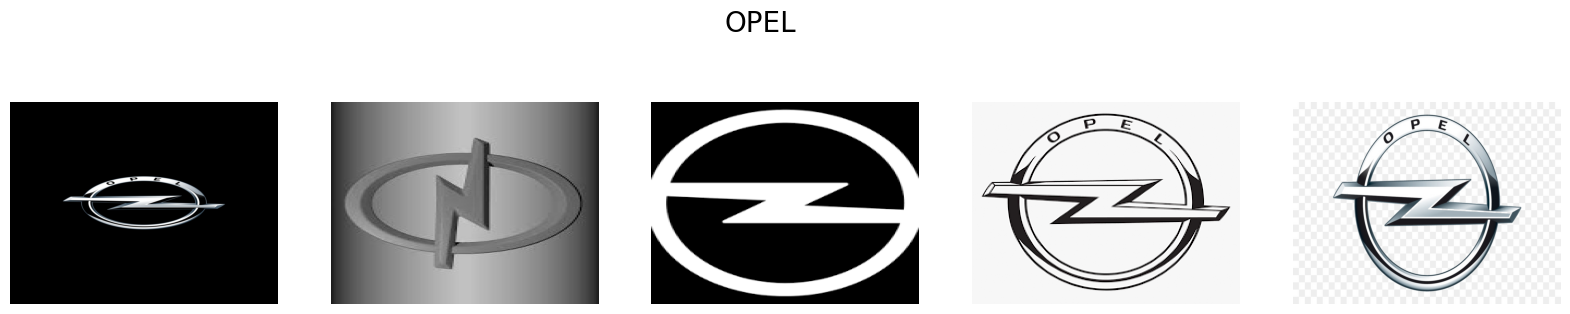

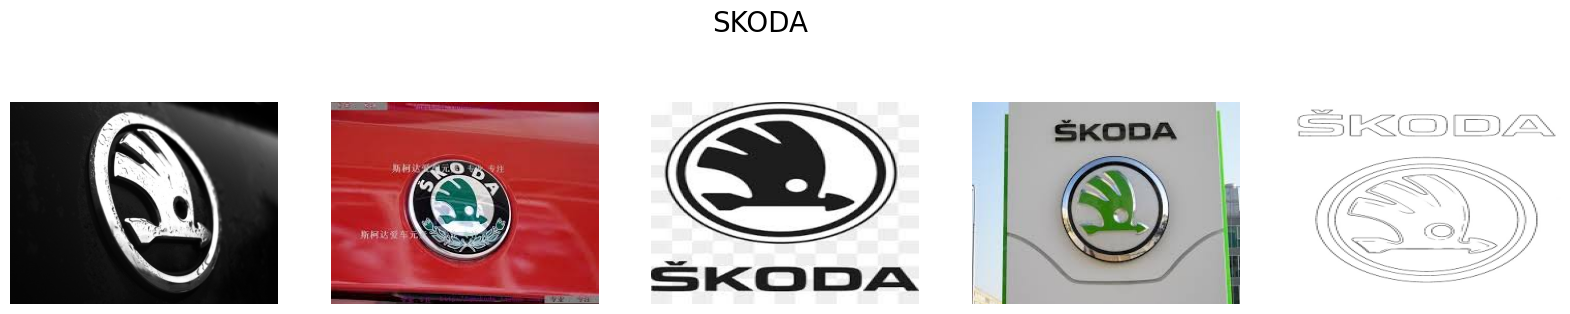

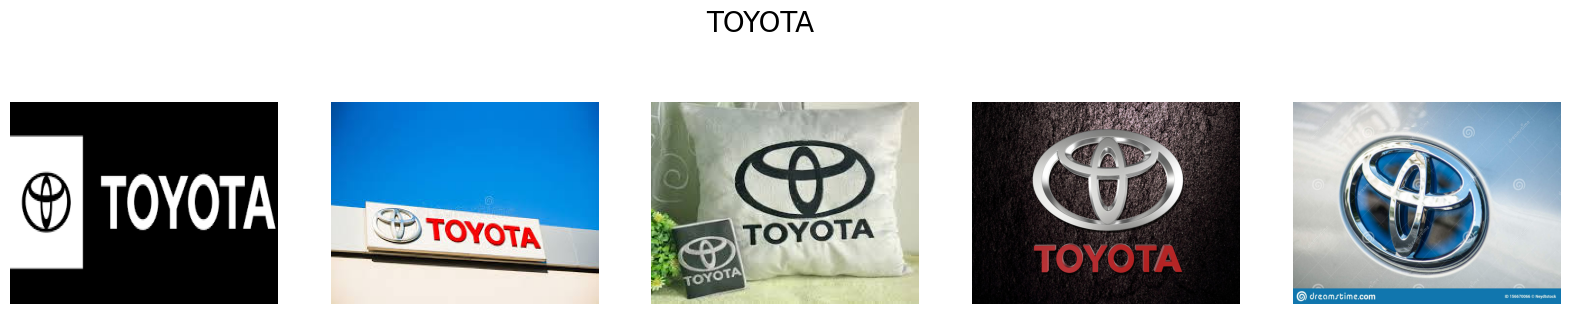

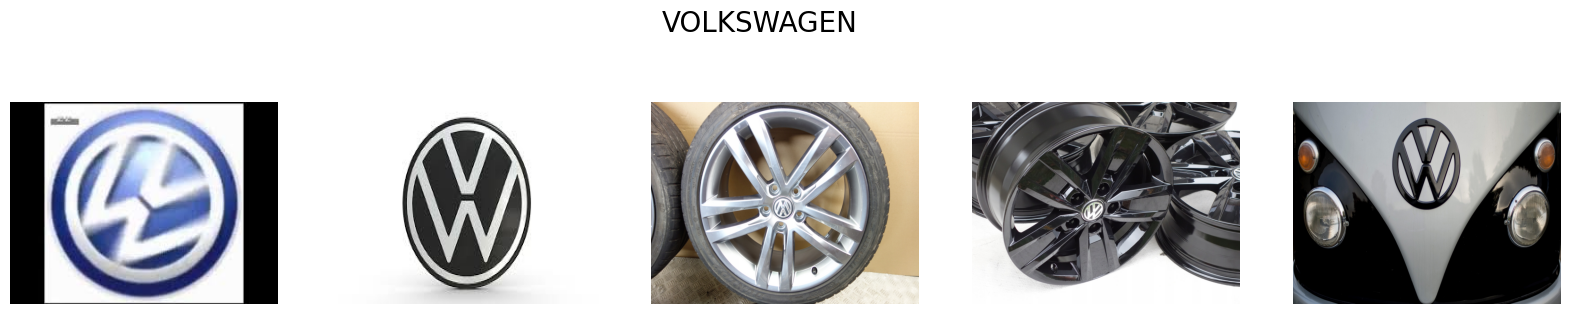

In [15]:
# Selecionar aleatoriamente 5 linhas para cada grupo de 'brand'
random_samples = df.groupby('brand').apply(lambda x: x.sample(5))

# Obter uma lista de marcas únicas
unique_brands = random_samples['brand'].unique()

# Iterar sobre cada marca única
for brand in unique_brands:
    # Selecionar aleatoriamente 5 linhas para a marca atual
    brand_samples = random_samples[random_samples['brand'] == brand]

    # Criar uma nova figura para a marca atual
    brand_plot = plt.figure(figsize=(20, 4))

    # Iterar sobre cada uma das 5 imagens selecionadas
    for i, (_, row) in enumerate(brand_samples.iterrows(), start=1):
        img = mpimg.imread(row['path'])
        plt.subplot(1, 5, i)
        plt.imshow(img, extent=(0, mean_width, 0, mean_height))
        plt.axis('off')

    # Adicionar título com o nome da marca para o gráfico atual
    brand_plot.suptitle(brand.upper(), fontsize=20)

    # Exibir o gráfico
    plt.show()
    print('\n'*3)

## **4. Preparação do Dataset**

Primeiramente, são definidos o tamanho do batch e as dimensões das imagens.

In [16]:
IMG_WIDTH = 250
IMG_HEIGHT = 250
BATCH_SIZE = 32
NUM_OF_BRANDS = 8

**`ImageDataGenerator`** é uma classe utilitária fornecida pelo TensorFlow para aumentar e pré-processar dados de imagens. É comumente usada em tarefas de deep learning, especialmente para classificação de imagens, para gerar imagens aumentadas (data augmentation) sob demanda durante o treinamento do modelo.

Dessa forma, carregamos as imagens de Treino, Teste e Validação.

In [17]:
train_df = df[df["Train"] == 1].copy()


train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col='path',
    y_col='brand',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

Found 2513 validated image filenames belonging to 8 classes.


In [18]:
validation_df = df[df["Validation"] == 1].copy()

validation_datagen = ImageDataGenerator(rescale=1.0/255)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validation_df,
    directory=None,
    x_col='path',
    y_col='brand',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

Found 200 validated image filenames belonging to 8 classes.


In [19]:
test_df = df[df["Test"] == 1].copy()

test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=None,
    x_col='path',
    y_col='brand',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 200 validated image filenames belonging to 8 classes.


## **5. Modelo de Deep Learning**

Este trabalho permite carregar um modelo previamente treinado, ou criar um novo modelo e treiná-lo.

### **5.1 Arquiteturas**

A função **`create_model`** é responsável por gerar modelos de deep learning de acordo com a arquitetura escolhida e previamente definida.

Ao centralizar a criação dos modelos, é possível simplificar a implementação e permite a incorporação de novas arquiteturas sem grandes modificações no código. Isso proporciona maior flexibilidade e agilidade no desenvolvimento e testes de diferentes modelos de deep learning.

Esta função recebe como parâmetro o nome cadastrado para aquela arquitetura do modelo.

In [20]:
def create_model(model_choice):

    if model_choice == "MODEL_1":
        # model ref: https://www.kaggle.com/code/ahmadjaved097/multiclass-image-classification-using-cnn
        return keras.models.Sequential([
            keras.layers.Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
            keras.layers.Activation('relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            keras.layers.BatchNormalization(),

            keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=keras.regularizers.l2(0.00005)),
            keras.layers.Activation('relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            keras.layers.BatchNormalization(),

            keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=keras.regularizers.l2(0.00005)),
            keras.layers.Activation('relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            keras.layers.BatchNormalization(),

            keras.layers.Flatten(),

            keras.layers.Dense(units=256, activation='relu'),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(units=NUM_OF_BRANDS, activation='softmax')
        ])

    if model_choice == "MODEL_2":
        return keras.models.Sequential([
            keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT,3)),
            keras.layers.MaxPooling2D((2,2)),
            keras.layers.Conv2D(64, (3,3), activation='relu'),
            keras.layers.MaxPooling2D((2,2)),
            keras.layers.Conv2D(128, (3,3), activation='relu'),
            keras.layers.MaxPooling2D((2,2)),
            keras.layers.Flatten(),
            keras.layers.Dense(128, activation='relu'),
            keras.layers.Dense(NUM_OF_BRANDS, activation='softmax')
        ])

    if model_choice == "MODEL_3":
        return keras.models.Sequential([
            keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT,3)),
            keras.layers.MaxPooling2D((2,2)),
            keras.layers.Conv2D(64, (3,3), activation='relu'),
            keras.layers.MaxPooling2D((2,2)),
            keras.layers.Conv2D(128, (3,3), activation='relu'),
            keras.layers.MaxPooling2D((2,2)),
            keras.layers.Flatten(),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(128, activation='relu'),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(64, activation='relu'),
            keras.layers.Dense(NUM_OF_BRANDS, activation='softmax')
        ])

    return None

A função **`train_model`** é encarregada de treinar modelos de deep learning utilizando os dados de treinamento fornecidos, permitindo que diferentes configurações de treinamento sejam testadas de forma rápida e eficiente no desenvolvimento de soluções de deep learning.

In [21]:
def train_model(model, train_generator, validation_generator, training_choice):
    set_seed(SEED)

    if training_choice == "TRAINING_1":
        reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)
        optimizer = keras.optimizers.Adam(learning_rate=0.001)
        model.compile(optimizer=optimizer, loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
        training_epochs = 70
        history = model.fit(train_generator, epochs=training_epochs, validation_data=validation_generator, callbacks=[reduce_lr])
        model_metrics = plot_model_metrics_from_training(history)
        save_model(model, model_metrics, training_choice)
        return

    if training_choice == "TRAINING_2":
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        training_epochs = 70
        history = model.fit(train_generator, epochs=training_epochs, validation_data=validation_generator)
        model_metrics = plot_model_metrics_from_training(history)
        save_model(model, model_metrics, training_choice)
        return


### **5.2 Escolhendo o modelo**

In [22]:
# Relação modelo e treinamento utilizado
RL_MODEL_TRAINING = {
    "MODEL_1" : "TRAINING_1",
    "MODEL_2" : "TRAINING_2",
    "MODEL_3" : "TRAINING_2"
}

PATH_LOAD_MODEL = "" #"/content/trained_model_2024-04-12T0400.h5"
MODEL_TO_CREATE = "MODEL_3"

In [23]:
MODEL_TYPE = "None"

if PATH_LOAD_MODEL and os.path.isfile(PATH_LOAD_MODEL):
    model = keras.models.load_model(PATH_LOAD_MODEL)
    print(f"Modelo {PATH_LOAD_MODEL.split('/')[-1]} carregado com sucesso")
    MODEL_TYPE = "Loaded"
else:
    if not os.path.isfile(PATH_LOAD_MODEL):
        print(f"Modelo {PATH_LOAD_MODEL.split('/')[-1]} não encontrado")
    model = create_model(MODEL_TO_CREATE)
    MODEL_TYPE = "Created"

model.summary()

Modelo  não encontrado
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 124, 124, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 61, 61, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 59, 59, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (Non

## **6. Treinamento do Modelo**

Se o modelo escolhido acabou de ser criado, é necessário realizar o seu treinamento, de acordo com o treinamento mapeado para ele. Ao final, são plotados os gráficos com a evolução do modelo durante as épocas.

Epoch 1/70
79/79 [==============================] - 34s 340ms/step - loss: 2.0959 - accuracy: 0.1409 - val_loss: 2.0467 - val_accuracy: 0.1800
Epoch 2/70
79/79 [==============================] - 25s 315ms/step - loss: 2.0407 - accuracy: 0.1926 - val_loss: 1.9936 - val_accuracy: 0.1950
Epoch 3/70
79/79 [==============================] - 25s 315ms/step - loss: 2.0203 - accuracy: 0.2149 - val_loss: 1.9720 - val_accuracy: 0.2100
Epoch 4/70
79/79 [==============================] - 25s 315ms/step - loss: 1.9702 - accuracy: 0.2595 - val_loss: 1.8988 - val_accuracy: 0.2700
Epoch 5/70
79/79 [==============================] - 25s 316ms/step - loss: 1.9096 - accuracy: 0.2905 - val_loss: 1.8788 - val_accuracy: 0.2550
Epoch 6/70
79/79 [==============================] - 25s 316ms/step - loss: 1.8638 - accuracy: 0.3160 - val_loss: 1.8298 - val_accuracy: 0.3050
Epoch 7/70
79/79 [==============================] - 25s 318ms/step - loss: 1.8005 - accuracy: 0.3482 - val_loss: 1.7459 - val_accuracy: 0.3600

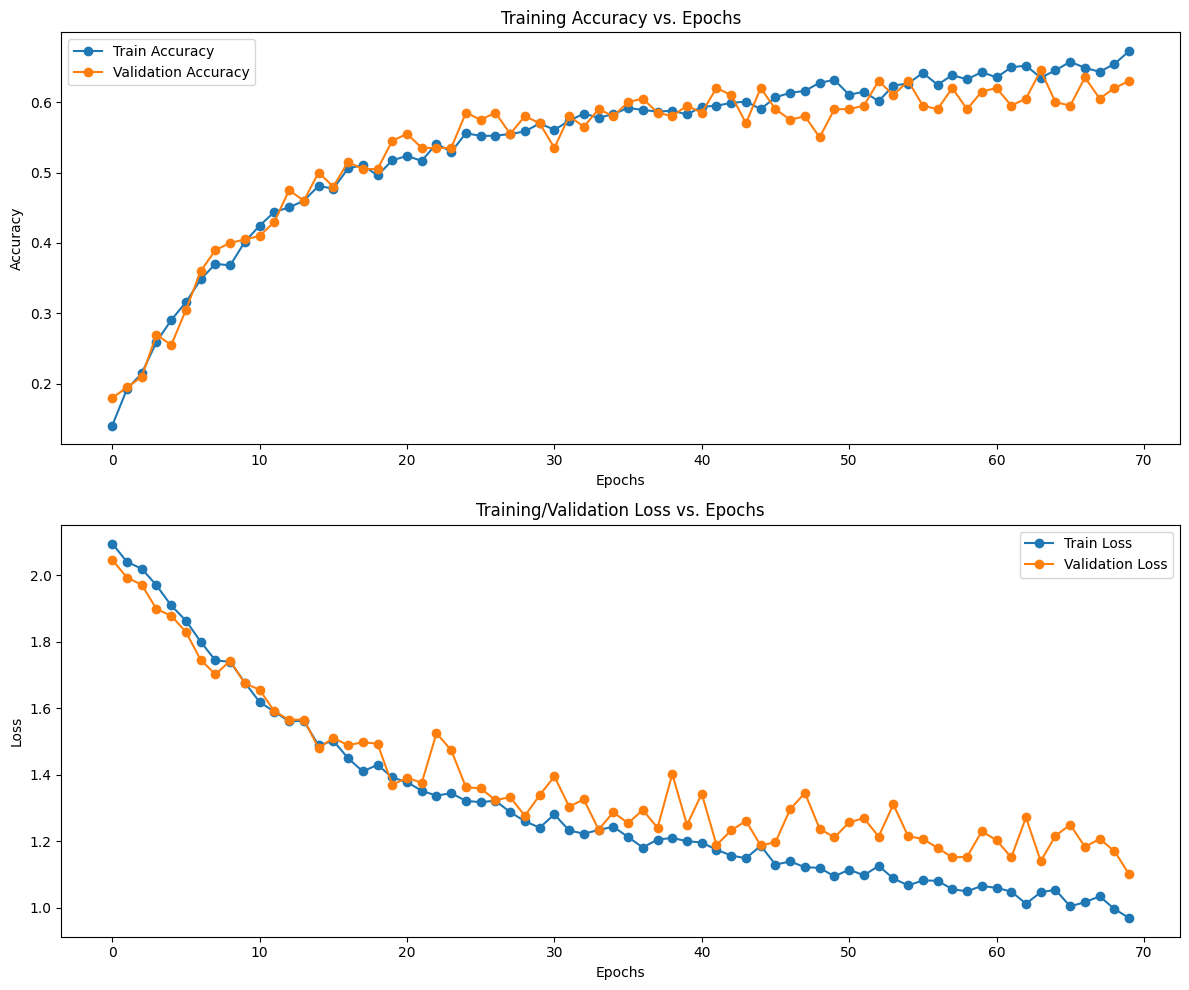

Modelo salvo:  trained_model_2024-04-15T0137.h5


In [24]:
if (MODEL_TYPE == "Created"):
    train_model(model, train_generator, validation_generator, RL_MODEL_TRAINING[MODEL_TO_CREATE])

Analisando os gráficos acima do treinamento do **"MODEL_3"**, é possível perceber que o modelo poderia começar a apresentar overfitting nos dados se houvesse mais épocas de treinamento.

Este modelo, diferentemente dos outros, possui duas camadas de Dropout, as quais permitiram contornar o overfitting que ocorria já na 20ª época do **"MODEL_2"** (que possui praticamente a mesma arquitetura:

In [25]:
IPython.display.Image(url="https://raw.githubusercontent.com/gffranca/DataAnalytics/main/MVP2/data/overfitting_metrics.png")

## **7. Teste/Execução do Modelo**

A seguir, o modelo é utilizado para realizar previsões nas instâncias do conjunto de testes, e os resultados das previsões para as 10 primeiras instâncias são exibidos. Para cada imagem, são apresentados o rótulo verdadeiro, o rótulo previsto pelo modelo e a confiança associada à previsão.

7/7 [==============================] - 1s 98ms/step


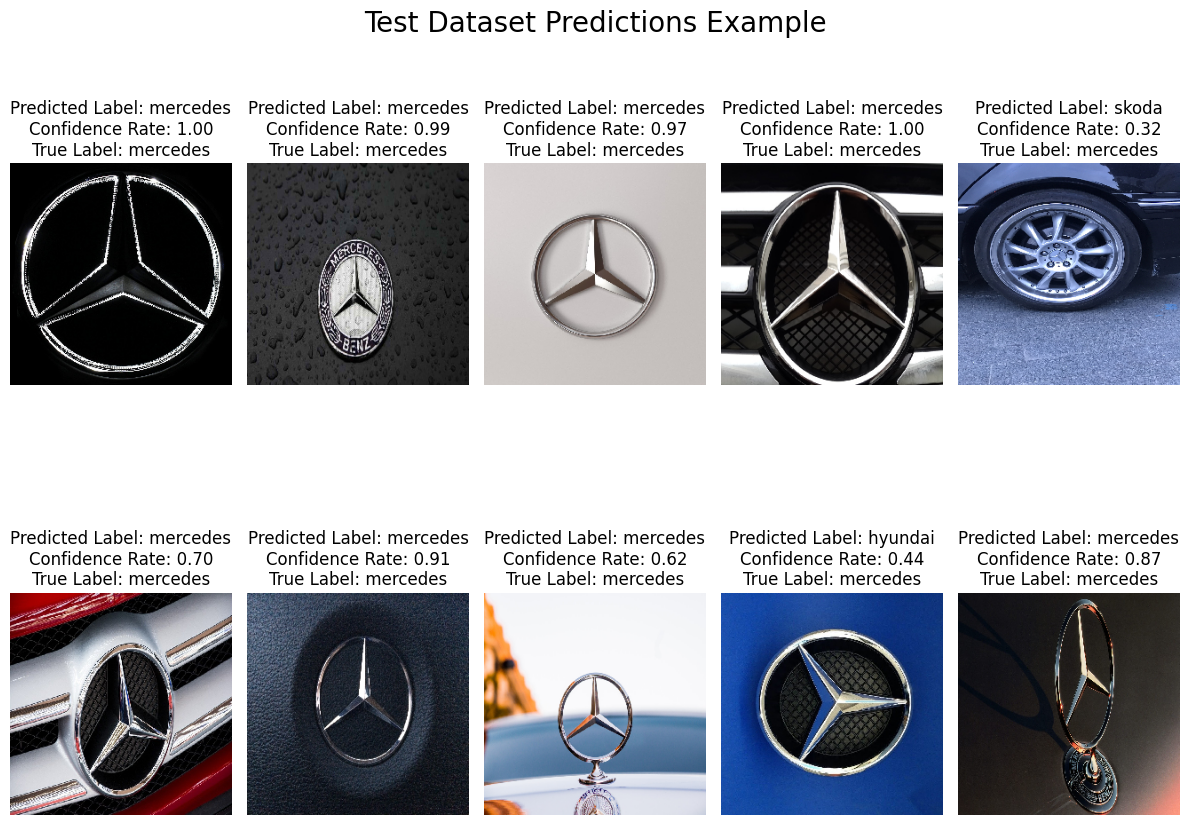

In [26]:
brand_names = {value: key for key, value in test_generator.class_indices.items()}

predictions = model.predict(test_generator)

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label_idx = np.argmax(predictions[idx])
        predicted_label = brand_names[predicted_label_idx]
        confidence = predictions[idx][predicted_label_idx]
        true_label = brand_names[test_generator.classes[idx]]
        ax[i, j].set_title(f"Predicted Label: {predicted_label}\nConfidence Rate: {confidence:.2f}\nTrue Label: {true_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions Example", fontsize=20)
plt.show()

### **7.1 Métricas e Resultados**

Se o modelo foi compilado com sucesso, indicado pela presença de um otimizador configurado, a função **`model.evaluate`** é empregada para avaliar o desempenho do modelo usando o conjunto de teste fornecido pelo test_generator. Esta função calcula a perda e a precisão do modelo com base nos dados de teste.

In [27]:
if model.optimizer:
    test_loss, test_accuracy = model.evaluate(test_generator, batch_size=BATCH_SIZE)

    print(f"Test Loss:     {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")

7/7 [==============================] - 1s 64ms/step - loss: 1.3611 - accuracy: 0.6750
Test Loss:     1.3610600233078003
Test Accuracy: 0.675000011920929


A função **`plot_confusion_matrix`** permite visualizar o desempenho do modelo, comparando os rótulos verdadeiros com os rótulos previstos para cada classe. Ao interpretar uma matriz de confusão, é importante observar a diagonal principal, que mostra o número de previsões corretas para cada classe.

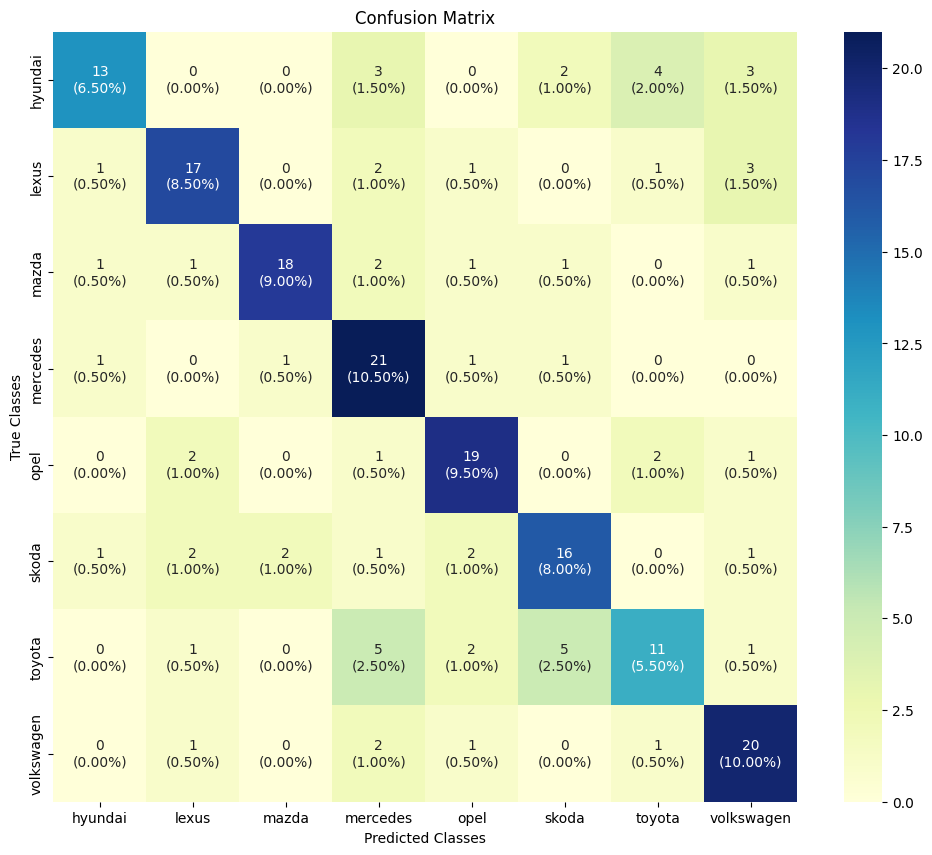

In [28]:
y_pred = np.array(np.argmax(predictions, axis=1))
y_true = np.array(test_generator.classes)

plot_confusion_matrix(y_true, y_pred, brand_names)

Observando a matriz de confusão, é possível identificarmos a diagonal principal que o desempenho do modelo foi satisfatório. Além disso, precebe-se que tanto a classe **'mercedes'** e **'volkswagen'** foram as marcas com maior quantidade de predições. Pode ser que isso tenha a ver com a quantidade de amostras de treino levemente superior que as demais, como é possível ver <a href="#scrollTo=kqlL3s_CwQhx&line=3&uniqifier=1">neste gráfico<a/>.

Através da função **`classification_report`**, é possível imprimir um relatório de classificação que fornece métricas de desempenho detalhadas para cada classe. Esta função calcula várias métricas, como precisão, recall, F1-score e suporte, para cada classe com base nos rótulos verdadeiros e nos rótulos previstos.

In [29]:
print(classification_report(y_true, y_pred, labels=range(len(brand_names)), target_names=brand_names.values()))

              precision    recall  f1-score   support

     hyundai       0.76      0.52      0.62        25
       lexus       0.71      0.68      0.69        25
       mazda       0.86      0.72      0.78        25
    mercedes       0.57      0.84      0.68        25
        opel       0.70      0.76      0.73        25
       skoda       0.64      0.64      0.64        25
      toyota       0.58      0.44      0.50        25
  volkswagen       0.67      0.80      0.73        25

    accuracy                           0.68       200
   macro avg       0.69      0.68      0.67       200
weighted avg       0.69      0.68      0.67       200



Através da função **`show_predictions_examples`**, é possível visualizar 10 casos de predições incorretas feitas pelo modelo no conjunto de teste. Esta função exibe exemplos onde o rótulo verdadeiro e o rótulo previsto são diferentes, destacando assim os erros cometidos pelo modelo.

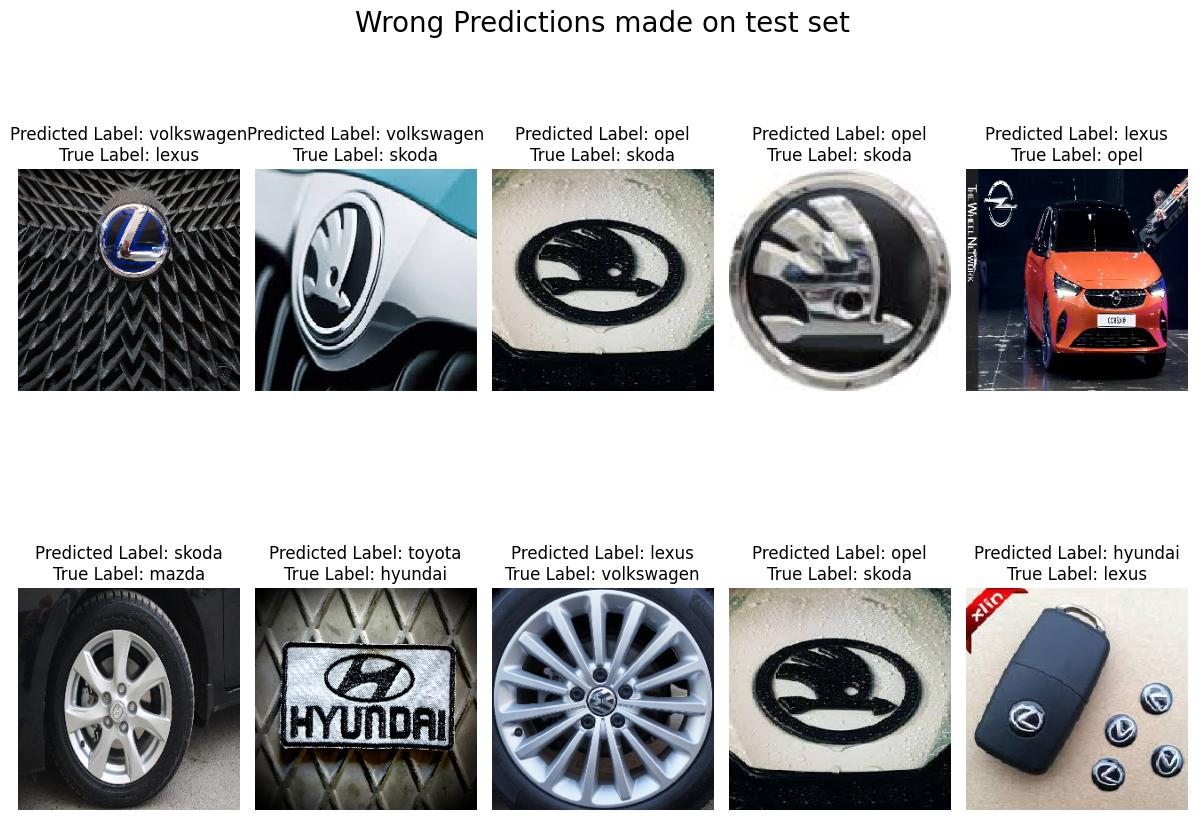

In [30]:
errors = (y_true - y_pred != 0)
show_predictions_examples(test_generator, y_true, y_pred, brand_names, errors, IMG_HEIGHT, IMG_WIDTH, 'Wrong Predictions made on test set')

De igual forma, é possível visualizar 10 casos de predições corretas feitas pelo modelo no conjunto de teste.

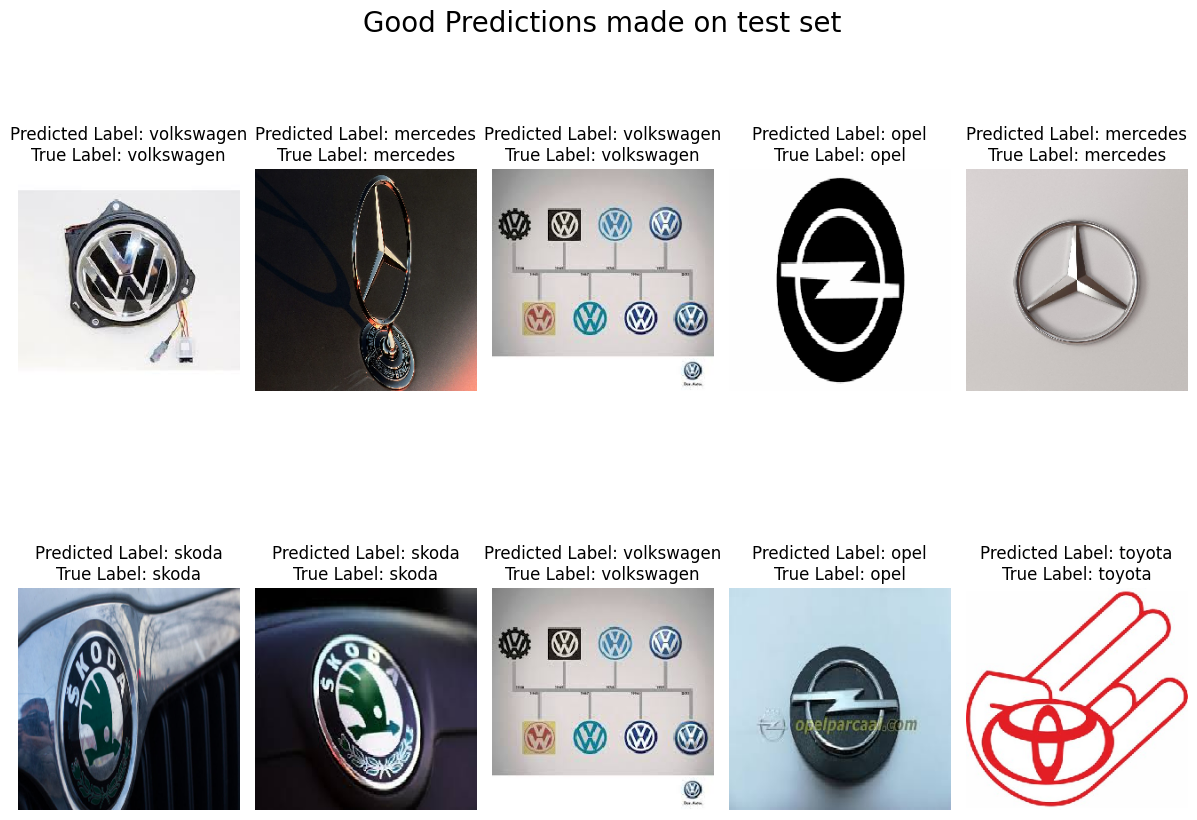

In [33]:
goods = (y_true - y_pred == 0)
show_predictions_examples(test_generator, y_true, y_pred, brand_names, goods, IMG_HEIGHT, IMG_WIDTH, 'Good Predictions made on test set')

## **8. Conclusões**

Os resultados obtidos foram satisfatórios, especialmente considerando a complexidade do dataset. Este conjunto de dados apresenta um desafio adicional, já que não se limita apenas às logos das marcas, mas inclui também objetos contendo essas logos. Essa variedade torna mais difícil a tarefa de identificar corretamente a classe real em alguns casos.

Apesar disso, o modelo conseguiu alcançar uma acurácia total média de quase 70%, demonstrando uma capacidade razoável de generalização e desempenho em um problema desafiador. No entanto, ainda há margem para refinamento, e estratégias adicionais, como aprimorar o *'data augmentation'* já feito e realizar o balanceamento das classes.